# Vector Space Semantics for Similarity between Eastenders Characters

Created a vector representation of a document containing lines spoken by a character in the Eastenders script data (i.e. from the file `training.csv`), then improved that representation such that each character vector is maximially distinguished from the other character documents. This distinction is measured by how well a simple information retrieval classification method can select documents from validation and test data as belonging to the correct class of document (i.e. deciding which character spoke the lines by measuring the similarity of those document vectors to those built in training).

As the lines are not evenly distributed in terms of frequency, only used a maximum of the first **400 lines** of each character in the training data to create the training documents, and a maximum of the first **40 lines** in the test data (from `test.csv`). This makes it more challenging, as number of lines spoken by a character can't be used directly or otherwise as a feature.




In [ ]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt

import nltk

from sklearn.feature_extraction import DictVectorizer

%matplotlib inline
pd.options.display.max_colwidth=500

In [ ]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
all_train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

# Inspect
all_train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE
...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE


In [ ]:
# Split into training and test data for heldout validation with random samples of 9:1 train/heldout split
from random import shuffle, seed

seed(0) # set a seed for reproducibility so same split is used each time

epsiode_scene_column = all_train_data.Episode.astype(str) + "-" + all_train_data.Scene.astype(str)
all_train_data['episode_scene'] = epsiode_scene_column
episode_scenes = sorted(list(set([x for x in epsiode_scene_column.values]))) # set function is random, need to sort!

shuffle(episode_scenes)

print(len(episode_scenes))
episode_split = int(0.9*len(episode_scenes))
training_ep_scenes = episode_scenes[:episode_split]
test_ep_scenes = episode_scenes[episode_split:]
print(len(training_ep_scenes), len(test_ep_scenes))

def train_or_heldout_eps(val):
    if val in training_ep_scenes:
        return "training"
    return "heldout"

all_train_data['train_heldout'] = all_train_data['episode_scene'].apply(train_or_heldout_eps)
all_train_data.shape

1394
1254 140


(15319, 8)

In [ ]:
print('Raw Data: ',np.shape(all_train_data))
train_data = all_train_data[all_train_data['train_heldout']=='training'].reset_index(drop=True)
val_data = all_train_data[all_train_data['train_heldout']=='heldout'].reset_index(drop=True)
print('Train set: ',np.shape(train_data))
print('Validation set: ',np.shape(val_data))

Raw Data:  (15319, 8)
Train set:  (13638, 8)
Validation set:  (1681, 8)


In [ ]:
train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender,episode_scene,train_heldout
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE,1350-1,training
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE,1350-1,training
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE,1350-2,training
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE,1350-2,training
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE,1350-2,training
...,...,...,...,...,...,...,...,...
13633,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE,1399-55,training
13634,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE,1399-55,training
13635,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE,1399-55,training
13636,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE,1399-55,training


In [ ]:
if False:
    # A simpler alternative to the above, but where a high split means some characters
    # may be left out
    print('Raw Data: ',np.shape(all_train_data))
    idx = int(0.9 * np.shape(all_train_data)[0])
    train_data = all_train_data[:idx]
    val_data = all_train_data[idx:]
    print('Train set: ',np.shape(train_data))
    print('Validation set: ',np.shape(val_data))

# Q3. Add dialogue context data and features (15 marks)
Adjusted `create_character_document_from_dataframe` to incorporate the context of the line spoken by the characters in terms of the lines spoken by other characters in the same scene (immediately before and after). 

In [ ]:
# Create one document per character
def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them.
    
    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}
    for idx, row in df.iterrows():
      name = row[3]
      if not name in character_docs.keys():
          character_docs[name] = ""
          character_line_count[name] = 0
      if character_line_count[name]==max_line_count:
          continue
      character_line_count[name]+=1

      if idx>0:
          previous = df.iloc[idx-1]
          character_docs[name] += " PRE_LINE_".join(str(previous[4]).split()) + " _EOL_PRE "  #Previous line

      character_docs[name] += str(row[4])+ " _EOL_ "

      if idx<len(df)-1:
          next= df.iloc[idx+1]
          character_docs[name] += " NEXT_LINE_".join(str(next[4]).split())+ " _EOL_NEXT "  #Next line
                 
    print("lines per character", character_line_count)
    return character_docs

In [ ]:
# print out the number of words each character has in the training set
# only use the first 360 lines of each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

lines per character {'SHIRLEY': 360, 'OTHER': 360, 'JACK': 360, 'RONNIE': 360, 'TANYA': 360, 'SEAN': 360, 'ROXY': 360, 'HEATHER': 360, 'MAX': 360, 'IAN': 360, 'JANE': 360, 'STACEY': 360, 'PHIL': 360, 'MINTY': 360, 'CHRISTIAN': 342, 'CLARE': 352}
Num. Characters:  16 

SHIRLEY Number of Words:  11548
OTHER Number of Words:  9617
JACK Number of Words:  11757
RONNIE Number of Words:  11808
TANYA Number of Words:  11066
SEAN Number of Words:  11117
ROXY Number of Words:  11578
HEATHER Number of Words:  12333
MAX Number of Words:  11892
IAN Number of Words:  12154
JANE Number of Words:  11545
STACEY Number of Words:  12045
PHIL Number of Words:  12465
MINTY Number of Words:  12397
CHRISTIAN Number of Words:  11264
CLARE Number of Words:  11903
total words 186489


# Q1. Improve pre-processing (10 marks)

Making changes to the pre_process function below to include word tokenizer,punctuation removal, stop words removal,numerals to words conversion,stemming and lemmatization

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
!pip install num2words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import num2words

# define the language for stopwords removal
stopwords = set(stopwords.words("english"))

def pre_process(character_text):
    """Pre-process all the concatenated lines of a character, 
    using tokenization, spelling normalization and other techniques.
    
    Initially just a tokenization on white space. Improve this for Q1.
    
    ::character_text:: a string with all of one character's lines
    """

    # Regular-expression based tokenizer, which splits text on whitespace and punctuation:
    tokens = wordpunct_tokenize(character_text.lower())

    #tokens = character_text.split() # just a simple tokenization, to be replaced

    #Punctuation 
    tokens = [re.sub(r'[^\w\s]', '', token) for token in tokens]
    
    # Stopwords removal
    tokens = [w for w in tokens if not w in stopwords]
    
    # Stemming
    # ps = PorterStemmer()
    # stemmed_sample_text = []
    # for token in tokens:
    #   stemmed_sample_text.append(ps.stem(token))
    # tokens = stemmed_sample_text

    #numerals to words
    for token in tokens:
      if token.isnumeric()==True:
        tokens[tokens.index(token)]=num2words.num2words(token)

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemma_sample_text = []
    for token in tokens:
      # remove empty token
      if token:
        lemma_sample_text.append(lemmatizer.lemmatize(token))
    tokens = lemma_sample_text
    return tokens

In [ ]:
# create list of pairs of (character name, pre-processed character) 
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Q2. Improve linguistic feature extraction (15 marks)
Used the feature extraction techniques to improve the `to_feature_vector_dictionary` function below. Commented the code for POS Tag,Previous and Next words.

In [ ]:
from nltk import bigrams

def to_feature_vector_dictionary(character_doc, extra_features=[]):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
    
    Initially just a simple count. Improve this for Q2.
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    counts = Counter(character_doc)  # for now a simple count
    counts = dict(counts)
    
    # add the extra features, for now just adding one count for each extra feature
    for feature in extra_features:
        counts[feature] += 1
    
    # add bigrams with their counts
    bi_counts = Counter(['@'.join(x) for x in bigrams(character_doc)])  
    bi_counts = dict(bi_counts)

    counts.update(bi_counts)

    '''
    #POS tags  
    tags=dict(nltk.pos_tag(character_doc))

    features={}
    for key, value in counts.items():
      values=[]

      #Adding Counts
      values.append("Count_"+str(value))

      #Adding POS tag 
      if key in tags:
        values.append("POS_"+str(tags[key]))
      
      for i in range(0,len(character_doc)):
        if(key==character_doc[i]):
            #Adding previous word
            if (character_doc[i-1]==character_doc[-1])|(character_doc[i-1]=='eol'):
              prev_word=" "
            else:
              prev_word=character_doc[i-1]
            values.append("PRE_"+str(prev_word))
            
            #Adding next word
            if ((i>=len(character_doc)-1)|(character_doc[i]=='eol')):
              next_word=" "
            else:
              next_word=character_doc[i+1]
              if next_word=='eol':
                next_word=" "
            values.append("NEXT_" +str(next_word))
            features[key]=values
      
      features[key+'_']=values
    
    features.update(counts)
    '''

    return counts 

# Q4. Improve the vectorization method (10 marks)
Used a matrix transformation technique TF-IDF to improve the `create_document_matrix_from_corpus` function along with dictionary vectorizor (`DictVectorizer`) and Select k best.


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import SelectKBest, chi2

corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here

#Creating a pipeline
pipe = Pipeline([('count', DictVectorizer()),('tfid', TfidfTransformer()),('selectkbest',SelectKBest(chi2, k=70000))])

def create_document_matrix_from_corpus(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.
    
    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.
    
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        pipe.fit([to_feature_vector_dictionary(doc) for name, doc in corpus],[name for name, doc in corpus])
    doc_feature_matrix = pipe.transform([to_feature_vector_dictionary(doc) for name, doc in corpus])
    print(doc_feature_matrix.shape)
    #training_feature_matrix[0].toarray()
    return doc_feature_matrix

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

(16, 70000)


In [ ]:
training_feature_matrix

<16x70000 sparse matrix of type '<class 'numpy.float64'>'
	with 81806 stored elements in Compressed Sparse Row format>

In [ ]:
# get the validation data- only 40 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

lines per character {'TANYA': 40, 'MAX': 40, 'SEAN': 35, 'SHIRLEY': 40, 'OTHER': 40, 'STACEY': 40, 'RONNIE': 40, 'JACK': 40, 'PHIL': 40, 'IAN': 40, 'JANE': 40, 'ROXY': 40, 'HEATHER': 40, 'MINTY': 40, 'CHRISTIAN': 40, 'CLARE': 40}
Num. Characters:  16 

TANYA Num of Words:  1260
MAX Num of Words:  1669
SEAN Num of Words:  1111
SHIRLEY Num of Words:  1439
OTHER Num of Words:  844
STACEY Num of Words:  1380
RONNIE Num of Words:  1166
JACK Num of Words:  1068
PHIL Num of Words:  1332
IAN Num of Words:  1322
JANE Num of Words:  1344
ROXY Num of Words:  1230
HEATHER Num of Words:  1206
MINTY Num of Words:  1471
CHRISTIAN Num of Words:  1192
CLARE Num of Words:  1425
total words 20459


In [ ]:
# Just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

(16, 70000)


In [ ]:
val_feature_matrix

<16x70000 sparse matrix of type '<class 'numpy.float64'>'
	with 4962 stored elements in Compressed Sparse Row format>

In [ ]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """
    
    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))
    
    return manual_cosine_similarity

In [ ]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents
    
    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i 
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )
    
    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [ ]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

In [ ]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

mean rank 1.75
mean cosine similarity 0.4736430892103445
12 correct out of 16 / accuracy: 0.75


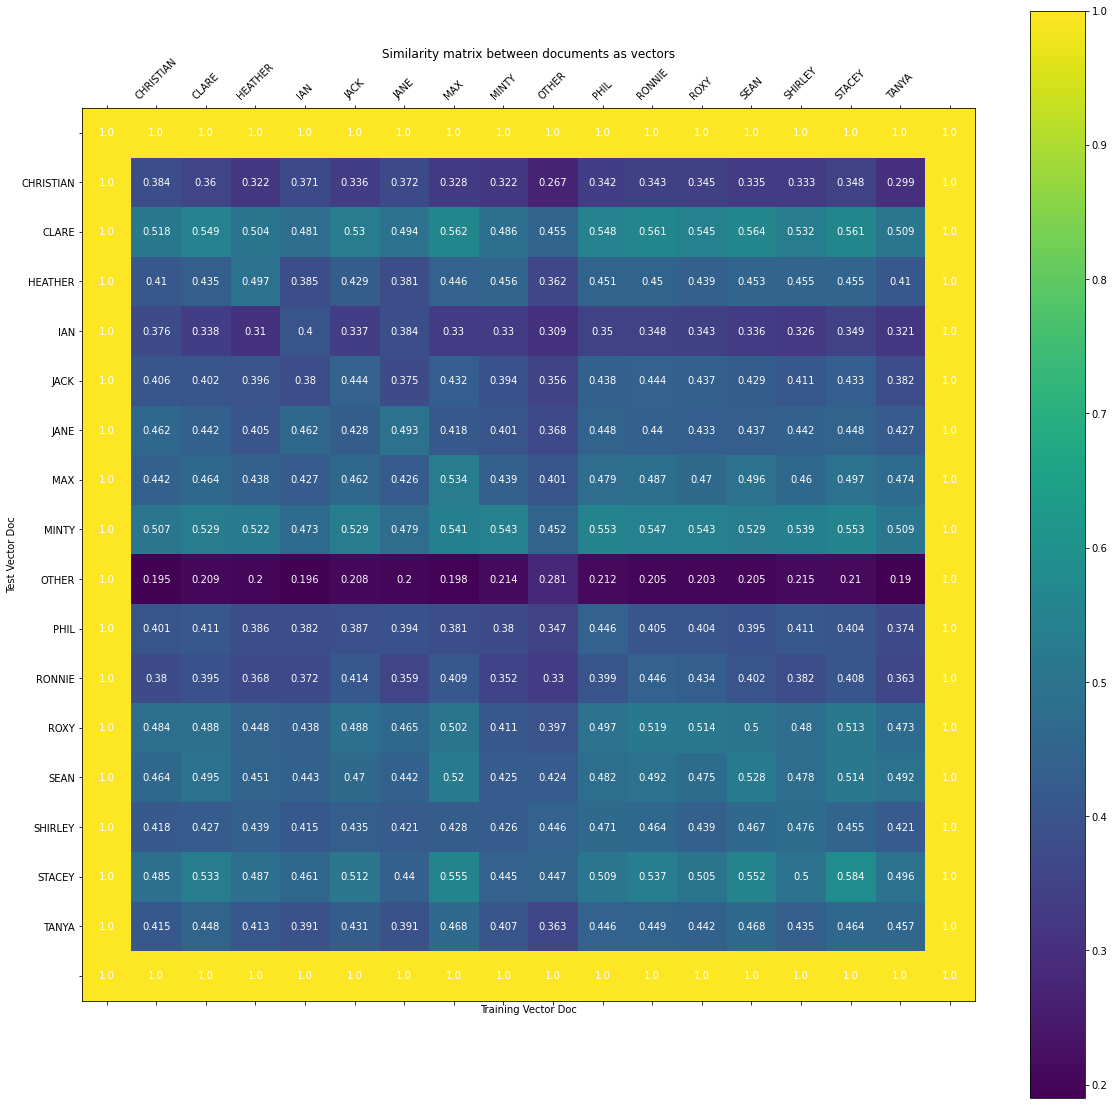

In [ ]:
plot_heat_map_similarity(df)

# Q5. Select and test the best vector representation method (10 marks)

For pre-processing made use of word tokenizer, punctuation removal, stop words removal, numerals to words conversion and lemmatization. Secondly, Included count of occurrences of words and bigrams as features. Thereby, made use of context by including previous and next lines in the character document. Lastly, included TfidfTransformer along with SelectKBest in the pipeline.

In [ ]:
# redo on all training data with the first 400 character lines used
train_character_docs = create_character_document_from_dataframe(all_train_data, max_line_count=400)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

training_corpus = [(name, pre_process(doc)) for name, doc in train_character_docs.items()]
train_labels = [name for name, doc in training_corpus]

corpusVectorizer = DictVectorizer()   # initialize a corpusVectorizor which will output sparse vectors from dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here

pipe = Pipeline([('count', DictVectorizer()),('selectkbest',SelectKBest(chi2, k=70000))])

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

# get the test data using 40 lines per character
test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=40)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
test_corpus = [(name, pre_process(doc)) for name, doc in test_character_docs.items()]
test_labels = [name for name, doc in test_corpus]


# Just transform the val_feature_matrix, don't fit
test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False)


mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

lines per character {'SHIRLEY': 400, 'OTHER': 400, 'JACK': 400, 'RONNIE': 400, 'TANYA': 400, 'SEAN': 400, 'ROXY': 400, 'HEATHER': 400, 'MAX': 400, 'IAN': 400, 'JANE': 400, 'STACEY': 400, 'PHIL': 400, 'MINTY': 400, 'CHRISTIAN': 385, 'CLARE': 400}
Num. Characters:  16 

SHIRLEY Number of Words:  12839
OTHER Number of Words:  10461
JACK Number of Words:  12840
RONNIE Number of Words:  13117
TANYA Number of Words:  12101
SEAN Number of Words:  12550
ROXY Number of Words:  12976
HEATHER Number of Words:  13447
MAX Number of Words:  13432
IAN Number of Words:  13591
JANE Number of Words:  12872
STACEY Number of Words:  13313
PHIL Number of Words:  13810
MINTY Number of Words:  13732
CHRISTIAN Number of Words:  12623
CLARE Number of Words:  13564
total words 207268
(16, 70000)
lines per character {'SHIRLEY': 40, 'OTHER': 40, 'HEATHER': 40, 'PHIL': 40, 'SEAN': 40, 'TANYA': 40, 'MAX': 40, 'JACK': 40, 'IAN': 40, 'JANE': 40, 'STACEY': 40, 'ROXY': 40, 'RONNIE': 40, 'CHRISTIAN': 40, 'MINTY': 40, 'C

Log of all mean ranks after each steps:

After Preprocessing:
mean rank 2.625
mean cosine similarity 0.9427518818336169
10 correct out of 16 / accuracy: 0.625

After feature addition:
mean rank 2.25
mean cosine similarity 0.9140963577560057
10 correct out of 16 / accuracy: 0.625

After dialouge context addition
mean rank 3.5
mean cosine similarity 0.8848562726805826
7 correct out of 16 / accuracy: 0.4375

After adding pipeline and applying tfidf and k best selection:
mean rank 1.75
mean cosine similarity 0.4736430892103445
12 correct out of 16 / accuracy: 0.75

For the final test data:
mean rank 1.875
mean cosine similarity 0.785859552286068
10 correct out of 16 / accuracy: 0.625



